АВТ-213 Гомзякова Софья

# Лабораторная работа №4

## Введение

### Цель работы

Изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

### Постановка задачи

1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

2. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

4. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

### Описание датасета

Ссылка на датасет: https://www.kaggle.com/datasets/sudhanshu2198/wheat-variety-classification/data

В датасете представлены параметры трех разных сортов пшеницы, по 70 для каждого вида:
- area - Площадь зерна $ A $;
- perimeter - Периметр зерна $ P $;
- compactness - Компактность зерна (выражается как $ \frac{4 \pi A}{P^2} $);
- length - Длина зерна;
- width - Ширина зерна;
- asymmetry coefficient - Коэффициент ассиметрии;
- groove length - Длина желобка на зерне;
- category - Сорт пшеницы (три закодированных значения - 0, 1, 2)

Все параметры представляются десятичными числами.

Был удален столбец category, так как он представляет собой класс, к которому относится данное измерение.

Столбцы area, perimeter, length, width - геометрические характеристики зерна, поэтому можно ожидать, что они будут коррелировать между собой и потребуется устранение мультиколлинеарности и уменьшение размерности.

## Ход работы

Импорт библиотек:

In [317]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score, rand_score, adjusted_rand_score, jaccard_score
)
from sklearn.metrics.cluster import contingency_matrix
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis as kurt, gaussian_kde
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, cdist
from scipy.optimize import linear_sum_assignment

Загрузка датасета:

In [318]:
df = pd.read_csv('wheat.csv')
true_classes = df['category']
df = df.drop(['category'], axis=1)

#### Дескриптивный анализ

In [319]:
print('Информация о датасете:')
df.info()
display(df.head())

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   area                   210 non-null    float64
 1   perimeter              210 non-null    float64
 2   compactness            210 non-null    float64
 3   length                 210 non-null    float64
 4   width                  210 non-null    float64
 5   asymmetry coefficient  210 non-null    float64
 6   groove length          210 non-null    float64
dtypes: float64(7)
memory usage: 11.6 KB


area  perimeter  compactness  length  width  asymmetry coefficient  \
0  15.26      14.84       0.8710   5.763  3.312                  2.221   
1  14.88      14.57       0.8811   5.554  3.333                  1.018   
2  14.29      14.09       0.9050   5.291  3.337                  2.699   
3  13.84      13.94       0.8955   5.324  3.379                  2.259   
4  16.14      14.99       0.9034   5.658  3.562                  1.355   

   groove length  
0          5.220  
1          4.956  
2          4.825  
3          4.805  
4          5.175

Датасет содержит 210 измерений и 7 столбцов. Все признаки представлены десятичными числами и не имеют пропущенных значений.

Описательный анализ:

In [320]:
display(df.describe())

area   perimeter  compactness      length       width  \
count  210.000000  210.000000   210.000000  210.000000  210.000000   
mean    14.847524   14.559286     0.870999    5.628533    3.258605   
std      2.909699    1.305959     0.023629    0.443063    0.377714   
min     10.590000   12.410000     0.808100    4.899000    2.630000   
25%     12.270000   13.450000     0.856900    5.262250    2.944000   
50%     14.355000   14.320000     0.873450    5.523500    3.237000   
75%     17.305000   15.715000     0.887775    5.979750    3.561750   
max     21.180000   17.250000     0.918300    6.675000    4.033000   

       asymmetry coefficient  groove length  
count             210.000000     210.000000  
mean                3.700201       5.408071  
std                 1.503557       0.491480  
min                 0.765100       4.519000  
25%                 2.561500       5.045000  
50%                 3.599000       5.223000  
75%                 4.768750       5.877000  
max                 8.456000       6.550000

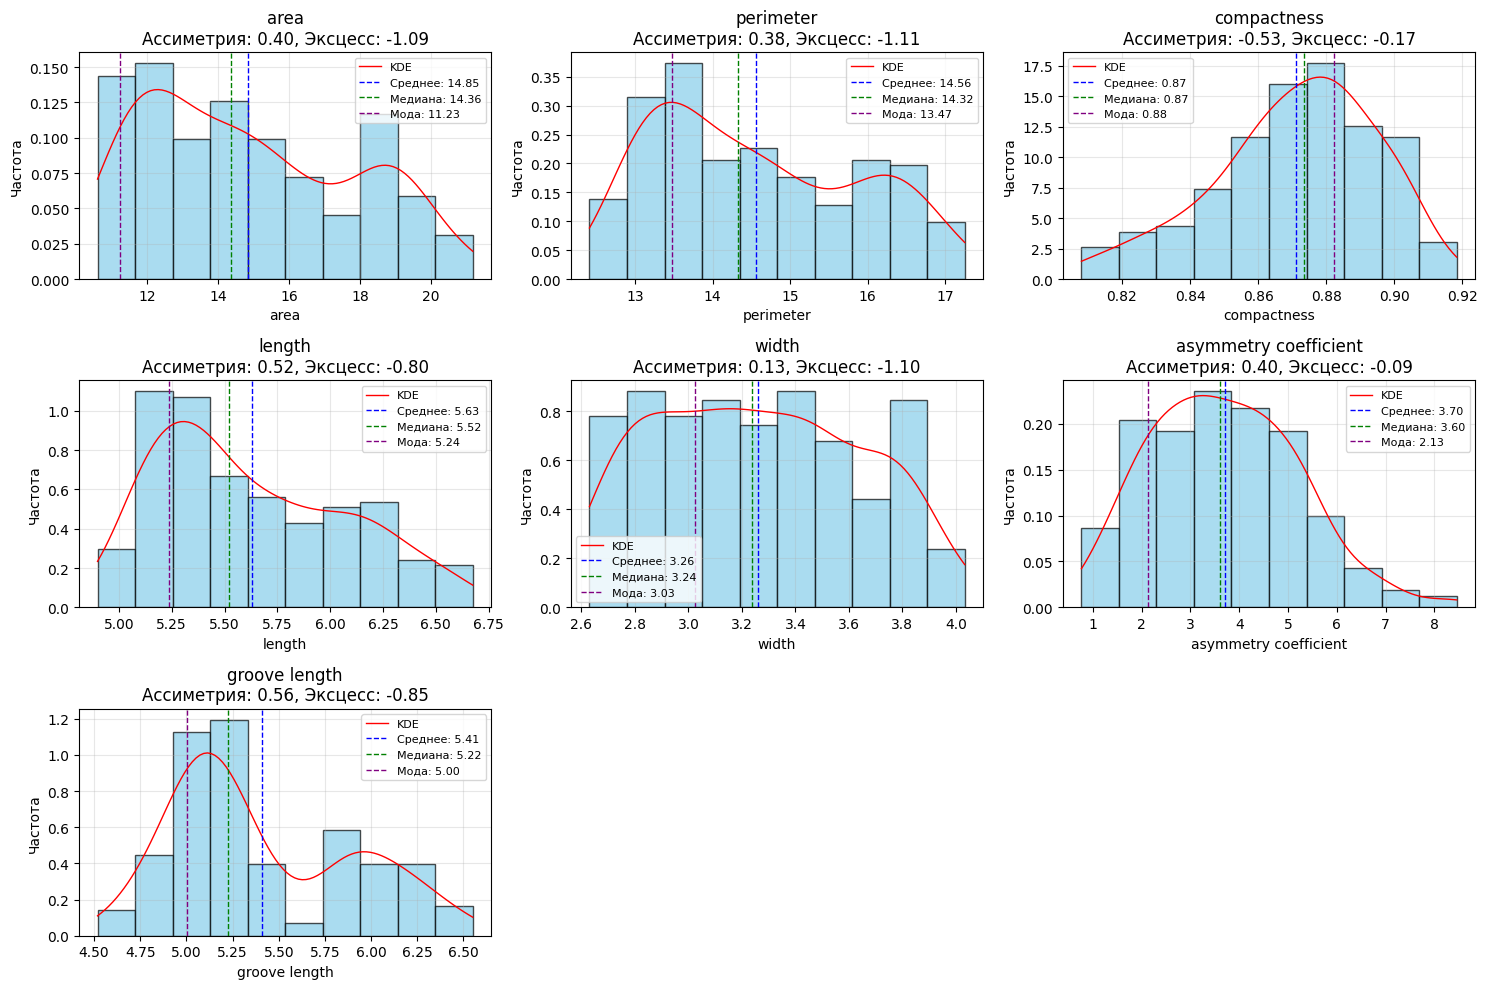

In [321]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    if i < len(axes):
        data = df[col]
        axes[i].hist(df[col], edgecolor='black', alpha=0.7, 
                                       color='skyblue', density=True)
        
        mean_val = data.mean()
        median_val = data.median()
        mode_val = data.mode()[0]
        skewness = skew(data)
        kurtosis = kurt(data)
        
        kde = gaussian_kde(data)
        x_range = np.linspace(data.min(), data.max(), 100)
        kde_curve = kde(x_range)
        axes[i].plot(x_range, kde_curve, 'r-', linewidth=1, label='KDE')
        
        axes[i].axvline(mean_val, color='blue', linestyle='--', linewidth=1, label=f'Среднее: {mean_val:.2f}')
        axes[i].axvline(median_val, color='green', linestyle='--', linewidth=1, label=f'Медиана: {median_val:.2f}')
        axes[i].axvline(mode_val, color='purple', linestyle='--', linewidth=1, label=f'Мода: {mode_val:.2f}')
        
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Частота')
        axes[i].set_title(f'{col}\nАссиметрия: {skewness:.2f}, Эксцесс: {kurtosis:.2f}')
        axes[i].legend(fontsize=8)
        axes[i].grid(True, alpha=0.3)

for i in range(len(df.columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Из всех признаков compactness ближе всего к нормальному распределению, с приближенно равными средним, медианой и модой, близким к 0 коэффициенту эксцесса и небольшой левосторонней ассиметрией.

area, perimeter, length и groove length имеют высокие коэффициенты эксцесса и ассиметрии и разброс между средним, медианой и модой. Также все эти признаки имеют две моды, так что можно предположить, что данные можно будет разбить как минимум на 2 кластера.

asymetry coefficient имеет почти нулевой эксцесс, но умеренную правостороннюю ассиметрию и смещенную влево моду.

width имеет большой показатель эксцесса (форма гистограммы с более тупой вершиной) и малый коэффициент ассиметрии и близкие значения среднего и медианы, однако также имеют сильно смещенную моду.

"Ящики с усами" для признаков:

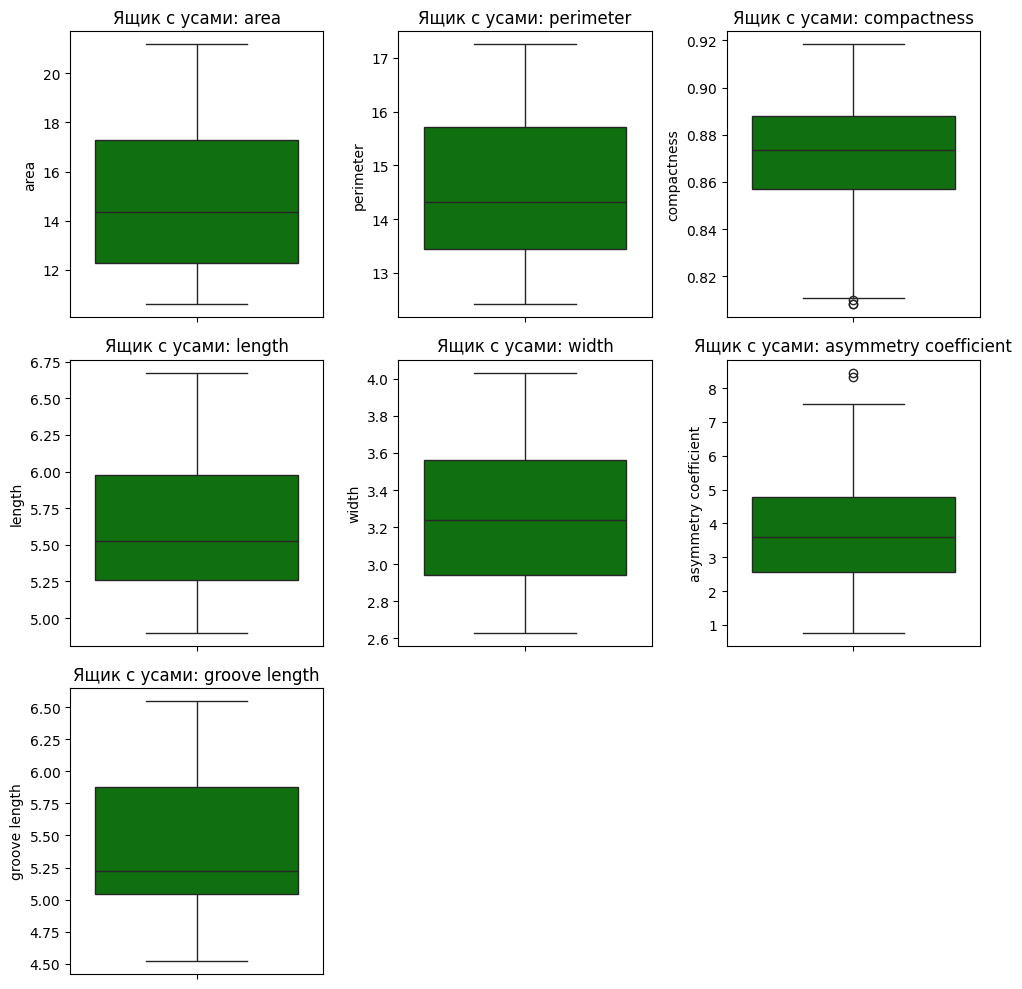

In [322]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    sns.boxplot(data=df[col], ax=axes[i], color='green')
    axes[i].set_title(f'Ящик с усами: {col}')

for i in range(len(df.columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

По графикам "ящиков с усами" есть небольшие выбросы у compactness и asymmetry coefficient в первом и последнем квартилях соответственно. У остальных признаков все измерения укладываются в размах между 25%-квартилем и 75%-квартилем (1.5 IQR). Также у groove length, area, length и perimeter можно наблюдать ассиметрию и смещенные медианы.

### Предобработка данных

Стандартизация используется, когда признаки имеют разный масштаб данных и когда используются методы, основанные на нормальном распределении или на расстоянии между измерениями / дисперсии, такие как K-Means. Также она сохраняет распределение данных.

Нормализация используется для алгоритмов, требующих определенный диапазон значений или перевод данных в другой диапазон, а также чувствительна к выбросам.

Для признаков из данного датасета больше подходит стандартизация.

In [323]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
y = df.columns

df_scaled = pd.DataFrame(X_scaled, columns=y)

display(df_scaled.describe().round(3))
display(df_scaled.head())

area  perimeter  compactness   length    width  \
count  210.000    210.000      210.000  210.000  210.000   
mean    -0.000      0.000        0.000   -0.000   -0.000   
std      1.002      1.002        1.002    1.002    1.002   
min     -1.467     -1.650       -2.668   -1.651   -1.668   
25%     -0.888     -0.851       -0.598   -0.829   -0.835   
50%     -0.170     -0.184        0.104   -0.238   -0.057   
75%      0.847      0.887        0.712    0.795    0.804   
max      2.182      2.065        2.007    2.368    2.055   

       asymmetry coefficient  groove length  
count                210.000        210.000  
mean                  -0.000         -0.000  
std                    1.002          1.002  
min                   -1.957         -1.813  
25%                   -0.759         -0.740  
50%                   -0.067         -0.377  
75%                    0.712          0.956  
max                    3.171          2.329

area  perimeter  compactness    length     width  \
0  0.142098   0.215462     0.000061  0.304218  0.141702   
1  0.011188   0.008224     0.428515 -0.168625  0.197432   
2 -0.192067  -0.360201     1.442383 -0.763637  0.208048   
3 -0.347091  -0.475333     1.039381 -0.688978  0.319508   
4  0.445257   0.330595     1.374509  0.066666  0.805159   

   asymmetry coefficient  groove length  
0              -0.986152      -0.383577  
1              -1.788166      -0.922013  
2              -0.667479      -1.189192  
3              -0.960818      -1.229983  
4              -1.563495      -0.475356

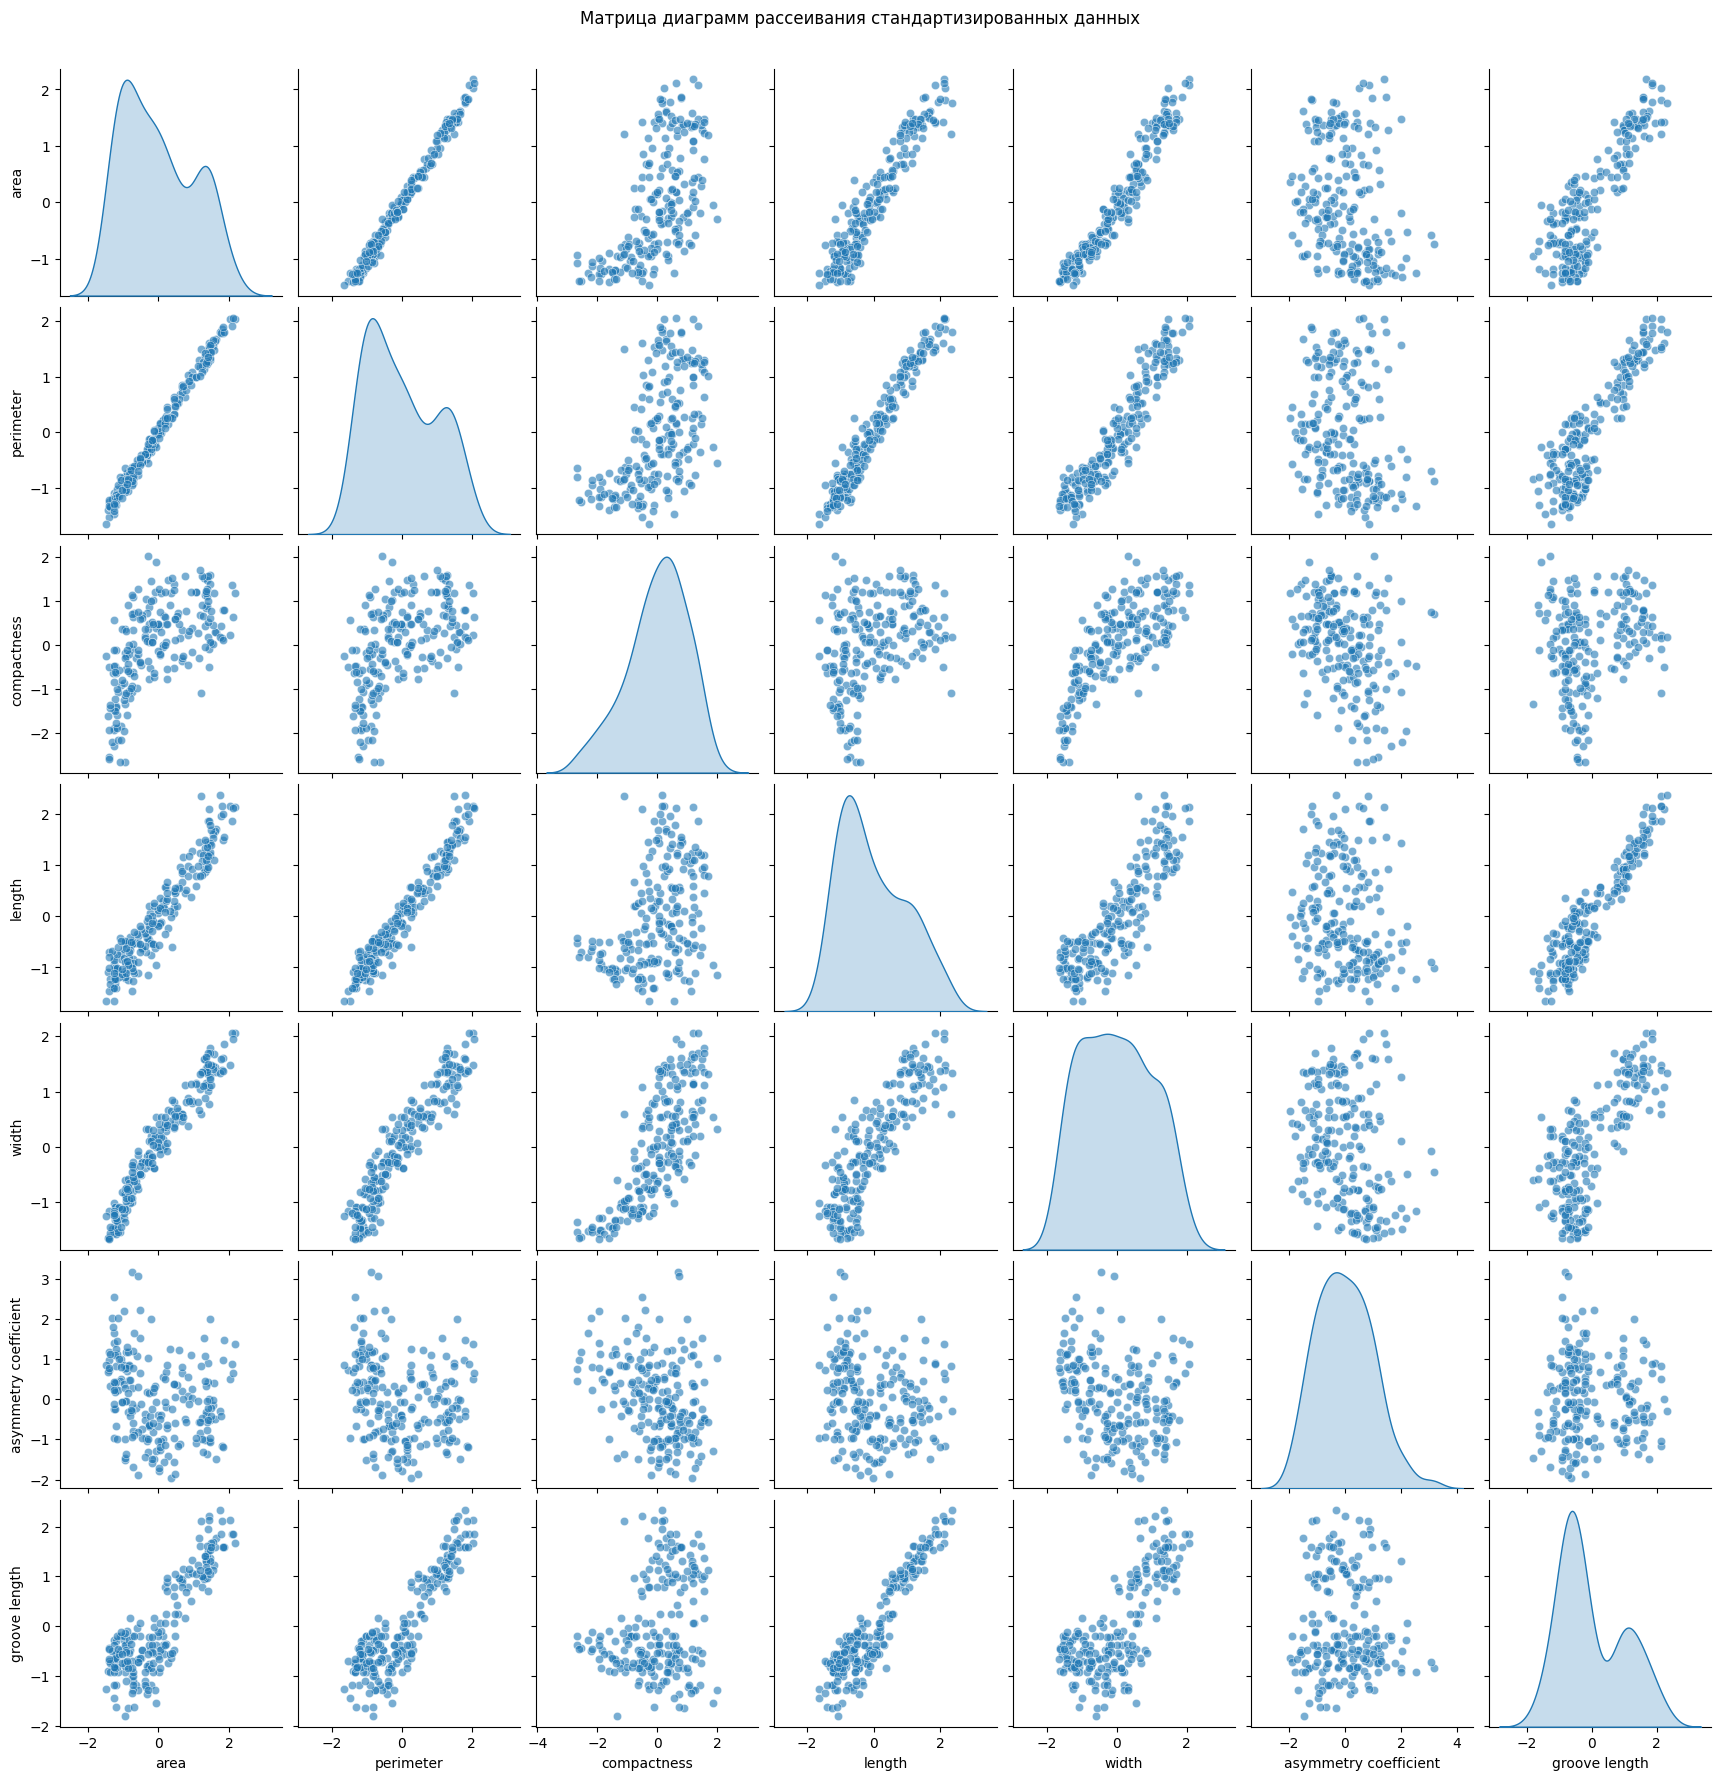

In [324]:
sns.pairplot(df_scaled, diag_kind='kde', plot_kws={'alpha':0.6})
plt.suptitle('Матрица диаграмм рассеивания стандартизированных данных', y=1.02)
plt.show()

На матрице диаграмм рассеивания можно четко наблюдать 2 кластерные структуры. Самые четкие разделения кластеров наблюдаются по groove length (кластеры более вытянутые и отдаленные), менее четко - по length (кластеры менее сгруппированны и более связанные между собой).

Предположительно в данном датасете можно выделить 2-3 кластера.

Также на диаграммах можно наблюдать сильную мультиколлинеарность. Корреляция может негативно повлиять на результаты кластеризации, поэтому был применен метод PCA для устранения мультиколлинеарности и уменьшения размерности.

Объясненная дисперсия PCA: [0.71874303 0.17108184 0.09685763]
Суммарная объясненная дисперсия 0.9867


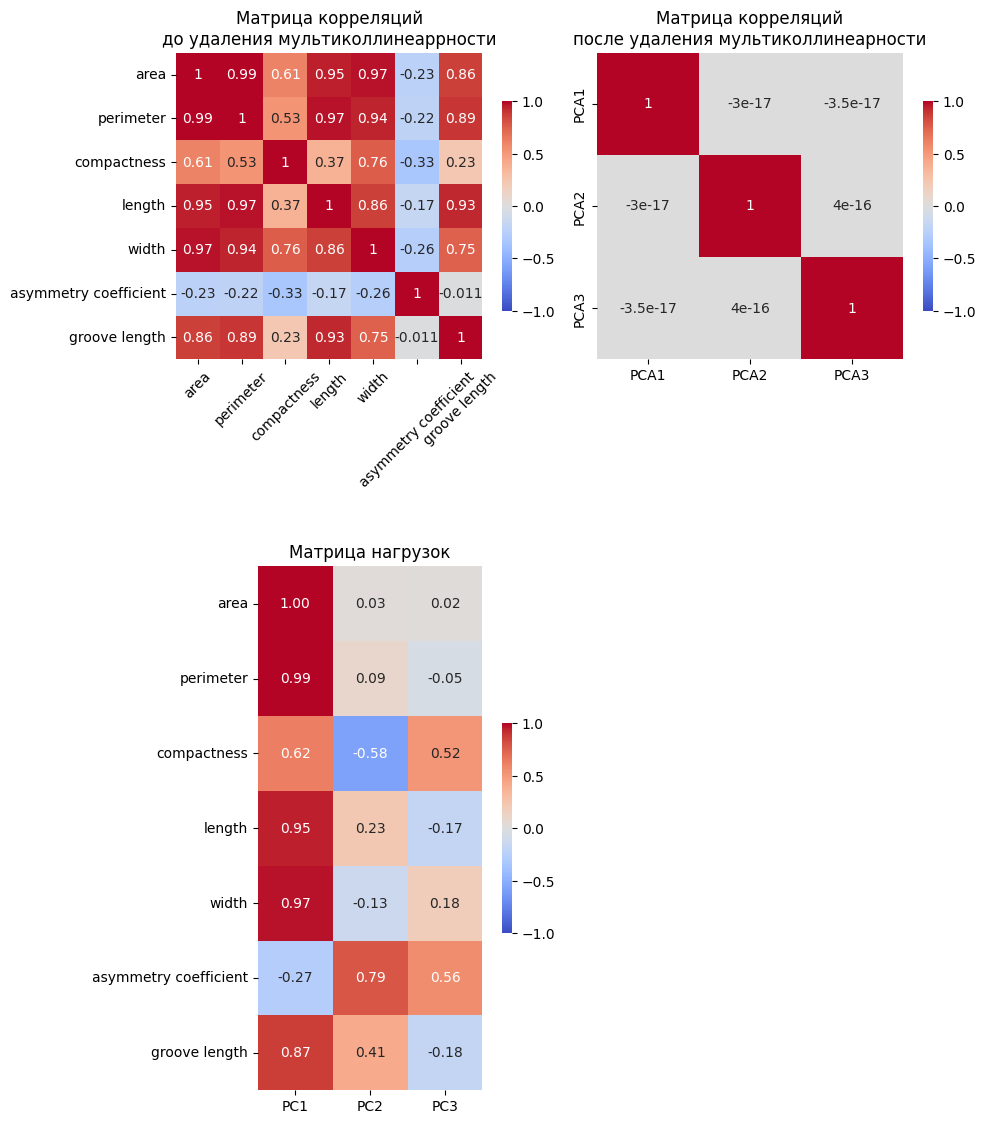

<Figure size 500x500 with 0 Axes>

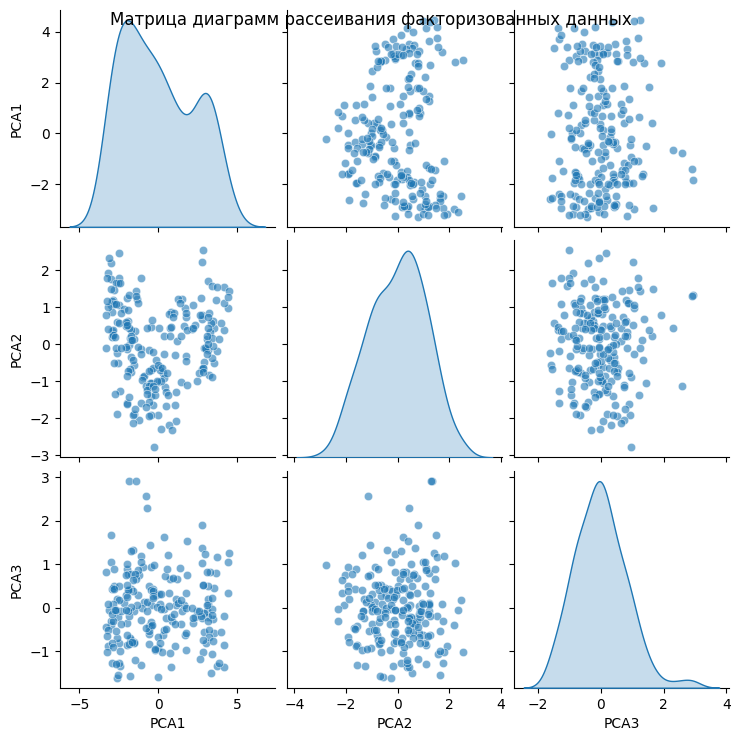

In [325]:
fig, axes = plt.subplots(2, 2, figsize=(10, 12))
axes = axes.flatten()

hm = sns.heatmap(df_scaled.corr(), cmap='coolwarm', vmax=1, vmin=-1,
                 annot=True, ax=axes[0], square=True, cbar_kws={'shrink': 0.4})
axes[0].set_title('Матрица корреляций\nдо удаления мультиколлинеаррности')
axes[0].set_xticklabels(df_scaled.columns, rotation=45)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

cols = [f'PCA{i+1}' for i in range(pca.n_components_)]
df_pca = pd.DataFrame(data=X_pca, columns=cols)
df_pca.head()

print(f"Объясненная дисперсия PCA: {pca.explained_variance_ratio_}")
print(f'Суммарная объясненная дисперсия {sum(pca.explained_variance_ratio_):.4f}')

hm2 = sns.heatmap(df_pca.corr(), cmap='coolwarm', vmax=1, vmin=-1,
                  annot=True, ax=axes[1], square=True, cbar_kws={'shrink': 0.4})
axes[1].set_title('Матрица корреляций\nпосле удаления мультиколлинеарности')

pca_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df_pca = pd.DataFrame(pca_loadings, 
                              index=df_scaled.columns,
                              columns=[f'PC{i+1}' for i in range(len(pca.components_))])
hm3 = sns.heatmap(loadings_df_pca.round(3),
                  annot=True, vmax=1, vmin=-1, cmap='coolwarm',
                  square=True, fmt='.2f', ax=axes[2], cbar_kws={'shrink': 0.4})
axes[2].set_title('Матрица нагрузок')

plt.delaxes(axes[3])

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(5, 5))

pp = sns.pairplot(df_pca, diag_kind='kde', plot_kws={'alpha':0.6})
plt.suptitle('Матрица диаграмм рассеивания факторизованных данных')

plt.show()

На диаграмме после PCA можно наблюдать 3 группы точек (на диаграммах рассеивания PCA1 с PCA2 и PCA3). Эти группы образуют разреженные округлые кластеры примерно одинакового размера.

Из-за близкого расположения кластеров и малой плотности алгоритм DBSCAN может быть неэффективным.

Так как кластеры округлые и сгруппированные, то для решения задачи кластеризации были выбраны методы K-Means и иерархическая классификация (агломеративная, то есть объединяющая).

### Кластеризация

Функция для оценки качества кластеризации (включая перенумерацию кластеров, чтобы можно было сравнить с реальными значениями):

In [326]:
def evaluate_clustering(X, labels, true_labels, method_name):
    cont_matrix = contingency_matrix(true_labels, labels)

    row_ind, col_ind = linear_sum_assignment(-cont_matrix)
    
    mapping = {}
    for i, j in zip(row_ind, col_ind):
        mapping[j] = i
    
    aligned_labels = np.array([mapping[label] for label in labels])

    unique_labels = np.unique(aligned_labels)
    n_clusters = len(unique_labels)
    sil = silhouette_score(X, aligned_labels)
    ch_score = calinski_harabasz_score(X, aligned_labels)
    db_score = davies_bouldin_score(X, aligned_labels)
    print(f"{method_name}:")
    print(f"Silhouette Score: {sil:.3f}")
    print(f"Индекс Калински–Харабаша: {ch_score:.3f}")
    print(f"индекс Дэвиса-Боулдина: {db_score:.3f}")
        
    cluster_compactness = []
    intra_cluster_distances = []
    cluster_centers = []
    
    for label in unique_labels:
        cluster_points = X[aligned_labels == label]
        if len(cluster_points) > 1:
            center = cluster_points.mean(axis=0)
            cluster_centers.append(center)
            
            distances_to_center = np.linalg.norm(cluster_points - center, axis=1)
            avg_intra_distance = np.mean(distances_to_center)
            intra_cluster_distances.append(avg_intra_distance)
            
            compactness = np.sum(distances_to_center ** 2)
            cluster_compactness.append(compactness)
            
            print(f"Кластер {label}: {len(cluster_points)} точек, "
                  f"среднее расстояние до центра: {avg_intra_distance:.3f}, "
                  f"компактность: {compactness:.3f}")

    if len(cluster_centers) > 1:
        center_distances = pdist(np.array(cluster_centers))
        print(f"Среднее расстояние между центрами кластеров: {np.mean(center_distances):.3f}")
        print(f"Минимальное расстояние между центрами кластеров: {np.min(center_distances):.3f}")
        print(f"Максимальное расстояние между центрам кластеров: {np.max(center_distances):.3f}")

    aligned_matrix = contingency_matrix(true_labels, aligned_labels)

    rand = rand_score(true_labels, aligned_labels)
    adjusted_rand = adjusted_rand_score(true_labels, aligned_labels)
    
    print(f"Индекс Rand: {rand:.3f}")
    print(f"Смещенный индекс Rand: {adjusted_rand:.3f}")
    
    jaccard = jaccard_score(true_labels, aligned_labels, average='macro')
    print(f"Индекс Жаккарда (macro): {jaccard:.3f}")


    print("\nМатрица сопряженности:")
    plt.figure(figsize=(3, 3))
    sns.heatmap(aligned_matrix, annot=True, vmin=0, cmap='Reds')
    plt.show()

    return aligned_labels, cluster_centers

#### K-Means

K-means (K-средних) — это алгоритм кластеризации, который разбивает набор данных на K отдельных непересекающихся групп (кластеров). Разбиение на кластеры происходит минимизацией дисперсии внутри кластеров (минимизацией расстояния между точками кластера и центроидом).

Основная идея заключается в том, что на каждой итерации перевычисляется центр масс для каждого кластера, полученного на предыдущем шаге, затем векторы разбиваются на кластеры вновь в соответствии с тем, какой из новых центров оказался ближе по выбранной метрике. Число кластеров известно заранее.

1. Начальные значения центроидов выбираются либо случайно, либо с помощью более продвинутых методов.
2. Каждая точка определяется в кластер на основании того, расстояние до центроида какого кластера минимально.
3. Новый центроид - среднее арифметическое положений всех точек кластера
4. Шаги 2-3 повторяются, пока центроиды не перестанут изменяться.

Подбор оптимального количества кластеров для метода K-Means:

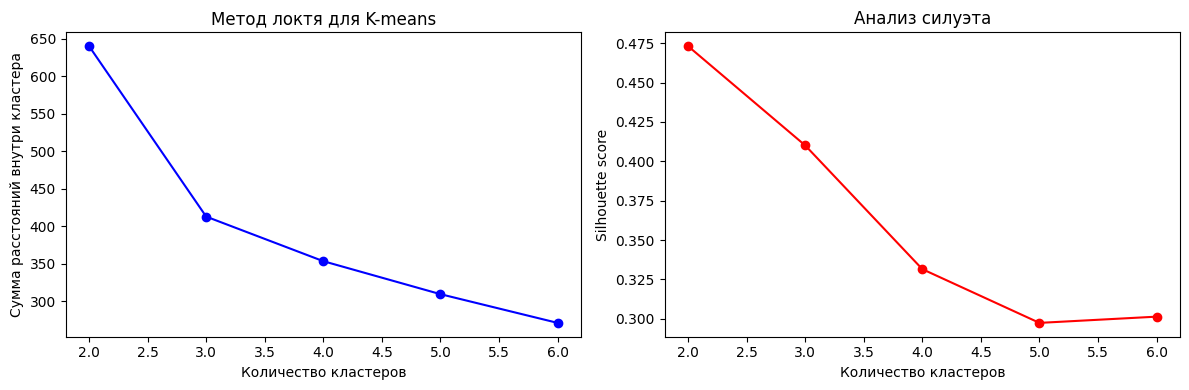

In [327]:
inertia = []
silhouette_scores = []
k_range = range(2, 7)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(k_range, inertia, 'bo-')
ax1.set_xlabel('Количество кластеров')
ax1.set_ylabel('Сумма расстояний внутри кластера')
ax1.set_title('Метод локтя для K-means')

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Количество кластеров')
ax2.set_ylabel('Silhouette score')
ax2.set_title('Анализ силуэта')

plt.tight_layout()
plt.show()

Для метода локтя оптимальное количество кластеров, определенное по точке локтя, 3

Для силуэтов максимум приходится на 2 кластера.

Для дальнейшей работы выбрано значение в 3 кластера.

Применение алгоритма K-Means для 3 кластеров:

K-means:
Silhouette Score: 0.410
Индекс Калински–Харабаша: 260.289
индекс Дэвиса-Боулдина: 0.903
Кластер 0: 72 точек, среднее расстояние до центра: 1.297, компактность: 144.944
Кластер 1: 67 точек, среднее расстояние до центра: 1.331, компактность: 134.301
Кластер 2: 71 точек, среднее расстояние до центра: 1.252, компактность: 133.409
Среднее расстояние между центрами кластеров: 3.733
Минимальное расстояние между центрами кластеров: 2.625
Максимальное расстояние между центрам кластеров: 5.150
Индекс Rand: 0.905
Смещенный индекс Rand: 0.785
Индекс Жаккарда (macro): 0.004

Матрица сопряженности:


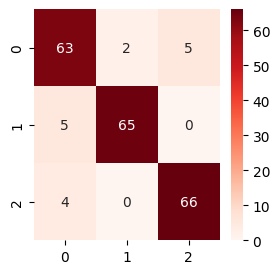


Центры кластеров K-means в исходных значениях:


area  perimeter  compactness    length     width  \
0  14.380107  14.272003     0.882044  5.477126  3.255784   
1  18.498466  16.219348     0.884008  6.192372  3.697190   
2  11.876268  13.284077     0.847521  5.250000  2.847589   

   asymmetry coefficient  groove length  
0               2.683376       5.160112  
1               3.641576       6.018461  
2               4.786669       5.083521

In [328]:
num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)

kmeans_labels, centers_pca = evaluate_clustering(X_pca, kmeans_labels, true_classes, "K-means")

print("\nЦентры кластеров K-means в исходных значениях:")

centers_scaled = pca.inverse_transform(centers_pca)
centers_original = scaler.inverse_transform(centers_scaled)

centers_df = pd.DataFrame(centers_original, 
                         columns=df_scaled.columns)
display(centers_df)

Было выделено 3 примерно одинакового размера кластера по 67-72 точки с внутренними метриками:
- Метод силуэта: 0.41 - умеренное качество, есть перекрытие между кластерами.
- Индекс Калински-Харабаша: 260.289 - высокий индекс, точки данных более распределенные.
- Индекс Дэвиса-Боулдвина: 0.903 - довольно низкий, но качество умеренное.

Сравнение с реальными значениями:
- Индекс Rand: 0.905 - 90,5% объектов правильно распределены.
- Скорректированный индекс Rand: 0.785 - с учетом случайности объекты все еще хорошо распредлеены.
- Индекс Жаккарда (macro): 0.004 - множества полученных кластеров и реальных кластеров хорошо пересекаются.

Кластер 0: 67 точек, среднее расстояние до центра: 1.331, компактность: 134.301

Кластер 1: 71 точек, среднее расстояние до центра: 1.252, компактность: 133.409

Кластер 2: 72 точек, среднее расстояние до центра: 1.297, компактность: 144.944

Среднее расстояние между центрами кластеров: 3.733

Минимальное расстояние между центрами кластеров: 2.625

Максимальное расстояние между центрам кластеров: 5.150

По центровым значениям кластеров можно определить их как:
- Кластер 0: средние размеры зерна, высокая компактность, малая ассиметрия, короткие желобки.
- Кластер 1: большие геометрические размеры зерна, высокая компактность, средняя ассиметрия, длинные желобки.
- Кластер 2: маленькие размеры зерна, низкая компактность, высокая ассиметрия, короткие желобки.

Визуализация кластеров на исходных данных и в двумерной проекции:

Объясненная дисперсия PCA' (для двумерного представления): [0.72844408 0.17339097]
Суммарная объясненная дисперсия 0.9018


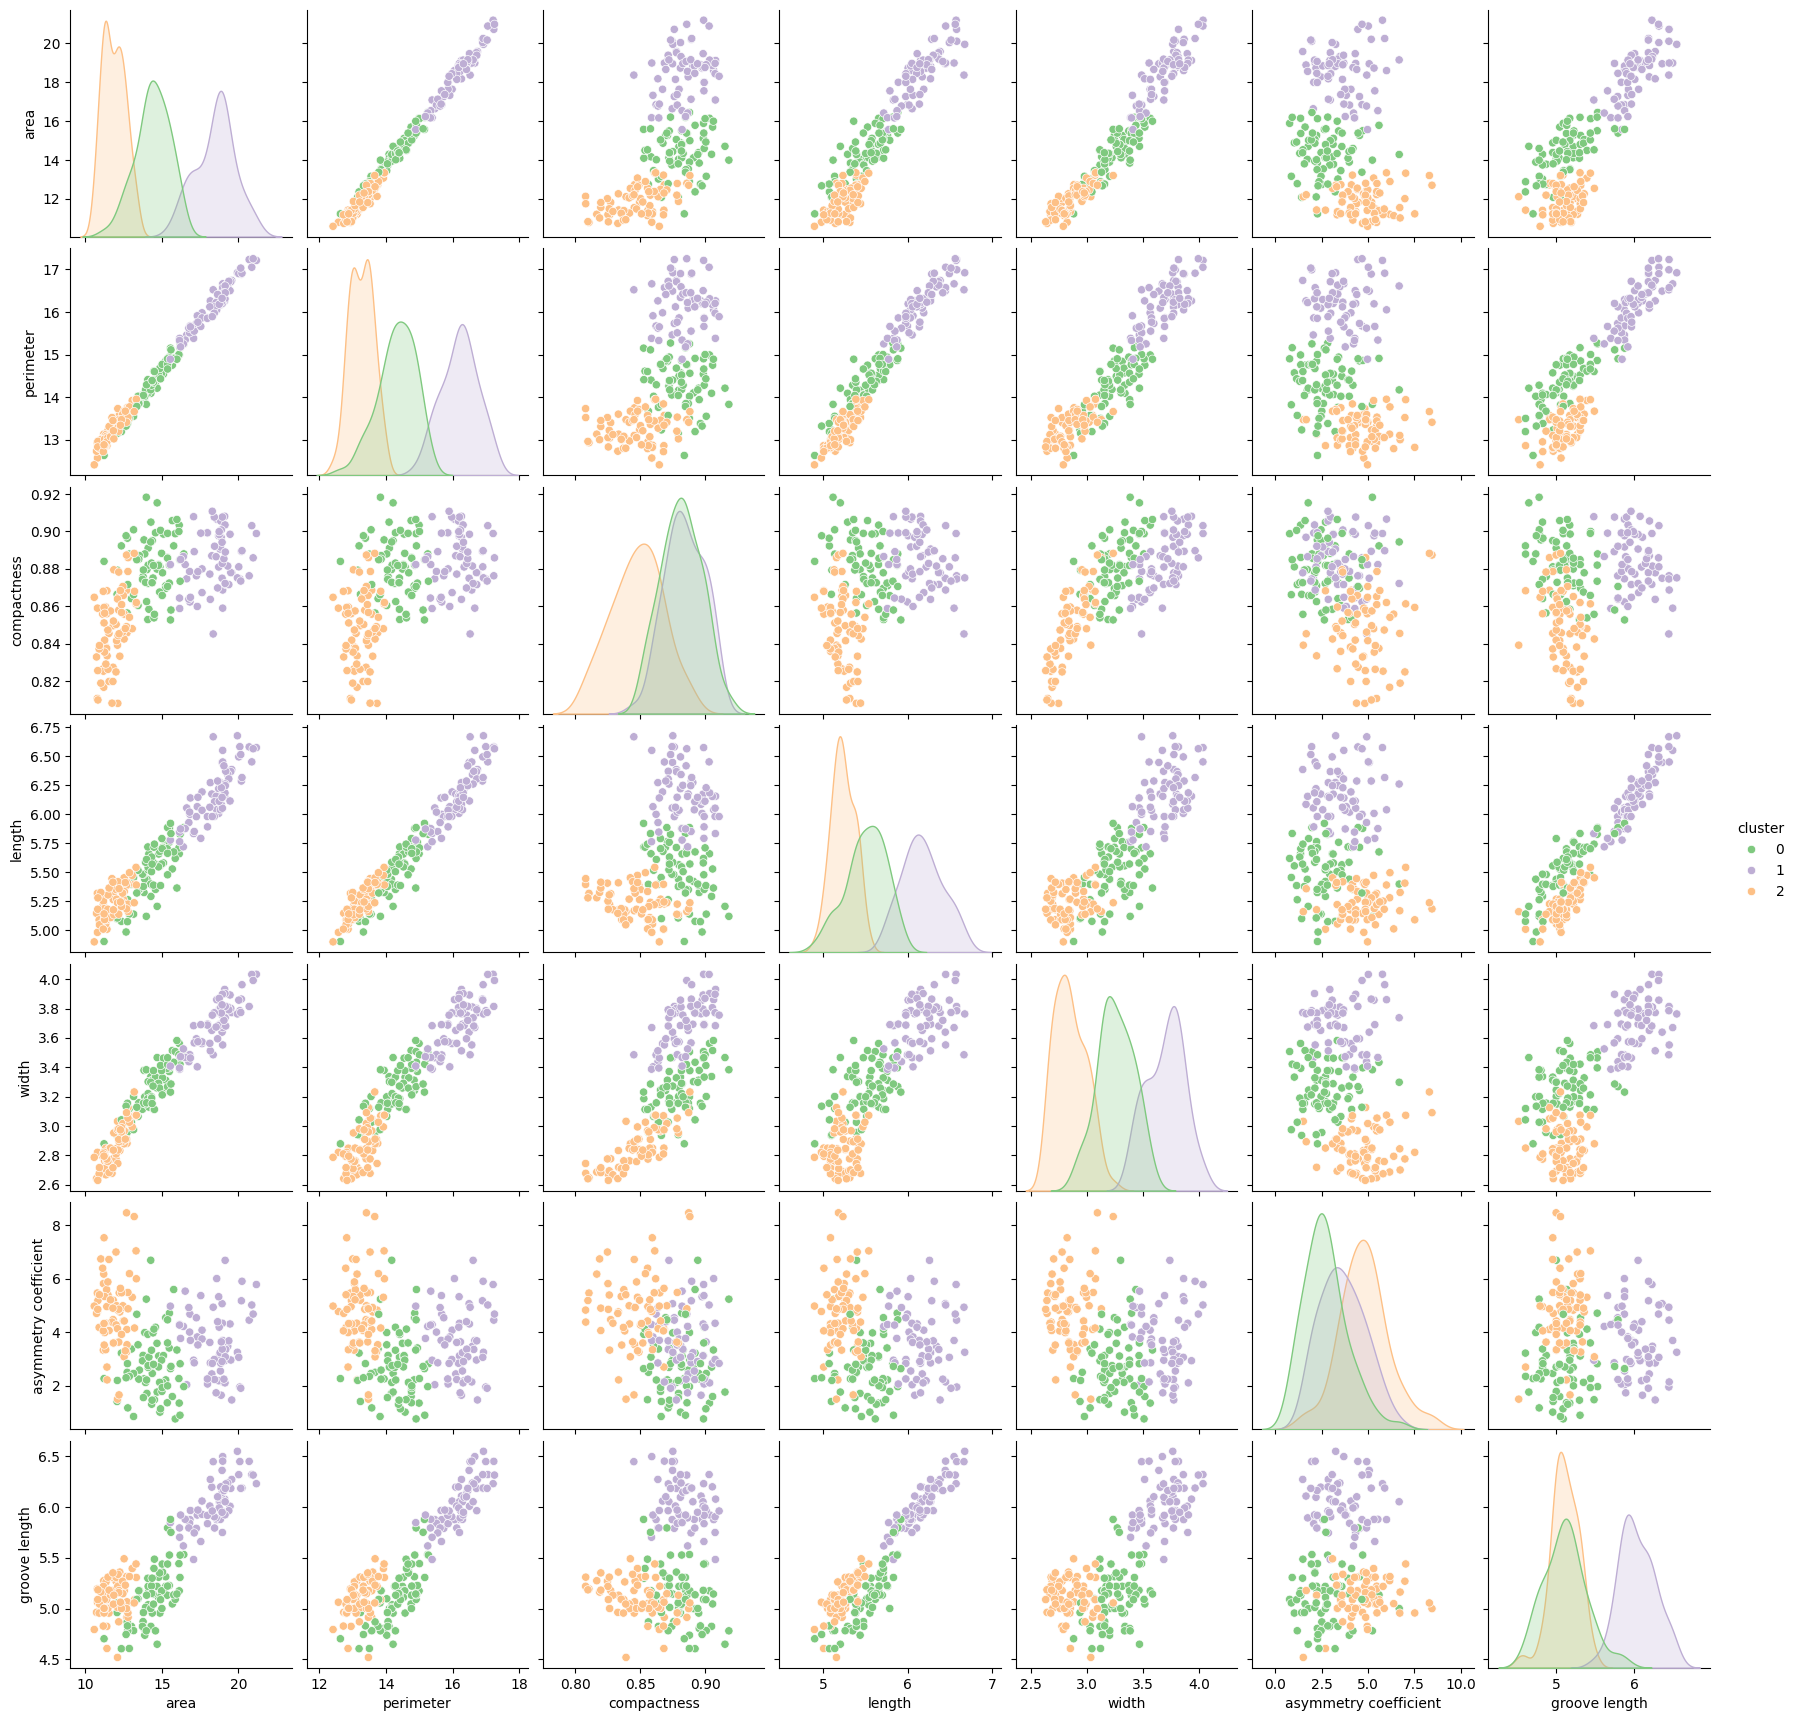

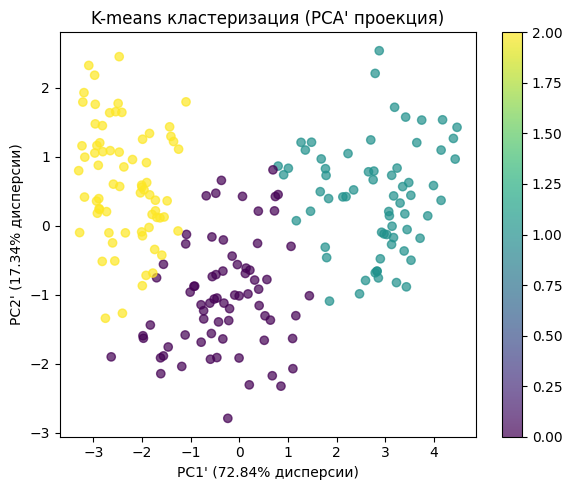

In [329]:
df_labels = df.copy()
df_labels = df_labels.assign(cluster=kmeans_labels)
sns.pairplot(df_labels, hue='cluster', palette='Accent')

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_pca)

cols = [f'PCA{i+1}\'' for i in range(pca_2d.n_components_)]
df_pca_2d = pd.DataFrame(data=X_pca_2d, columns=cols)
df_pca_2d = df_pca_2d.assign(cluster=kmeans_labels)

print(f"Объясненная дисперсия PCA' (для двумерного представления): {pca_2d.explained_variance_ratio_}")
print(f'Суммарная объясненная дисперсия {sum(pca_2d.explained_variance_ratio_):.4f}')

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

scatter1 = ax1.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
ax1.set_title('K-means кластеризация (PCA\' проекция)')
ax1.set_xlabel(f'PC1\' ({pca_2d.explained_variance_ratio_[0]:.2%} дисперсии)')
ax1.set_ylabel(f'PC2\' ({pca_2d.explained_variance_ratio_[1]:.2%} дисперсии)')
plt.colorbar(scatter1, ax=ax1)

plt.tight_layout()
plt.show()

У выделенных кластеров четкие границы, сами кластеры разреженные, чуть вытянутые.

### Агломеративная иерархическая кластеризация

Агломеративная иерархическая кластеризация - метод кластеризации, при котором новые кластеры создаются путем объединения более мелких кластеров, образуя дерево от листьев к корню.

Расстояние между объектами измеряется методом Ворда как прирост суммы квадратов расстояний объектов до центра кластера, получаемого в результате их объединения. На каждом шаге алгоритма объединяются такие два кластера, которые приводят к минимальному увеличению дисперсии.

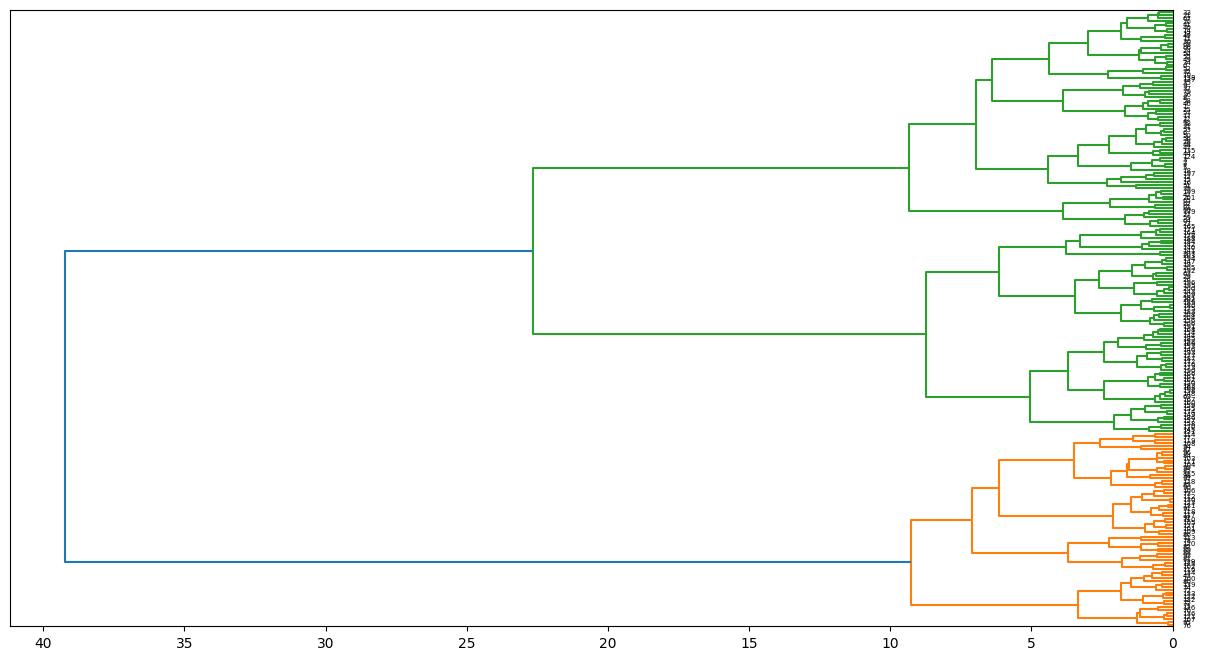

In [330]:
hc = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
tree_labels = hc.fit_predict(X_pca)

Z = linkage(X_pca, method='ward')
plt.figure(figsize=(15,8))
ax = plt.subplot(1, 1, 1)
r = dendrogram(Z, orientation='left', ax=ax, show_leaf_counts=True)

Иерархическая кластеризация:
Silhouette Score: 0.403
Индекс Калински–Харабаша: 249.660
индекс Дэвиса-Боулдина: 0.907
Кластер 0: 74 точек, среднее расстояние до центра: 1.360, компактность: 166.253
Кластер 1: 66 точек, среднее расстояние до центра: 1.347, компактность: 135.348
Кластер 2: 70 точек, среднее расстояние до центра: 1.221, компактность: 123.472
Среднее расстояние между центрами кластеров: 3.740
Минимальное расстояние между центрами кластеров: 2.669
Максимальное расстояние между центрам кластеров: 5.104
Индекс Rand: 0.905
Смещенный индекс Rand: 0.784
Индекс Жаккарда (macro): 0.002

Матрица сопряженности:


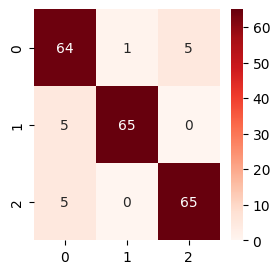


Центры кластеров иерархической кластеризации в исходных значениях:


area  perimeter  compactness    length     width  \
0  14.377969  14.272711     0.881972  5.477906  3.254696   
1  18.480562  16.213834     0.883431  6.192592  3.693055   
2  11.918473  13.302234     0.847676  5.255941  2.853112   

   asymmetry coefficient  groove length  
0               2.580128       5.156790  
1               3.715932       6.023479  
2               4.869447       5.093470

In [331]:
tree_labels, centers_pca = evaluate_clustering(X_pca, tree_labels, true_classes, "Иерархическая кластеризация")

print("\nЦентры кластеров иерархической кластеризации в исходных значениях:")

centers_scaled = pca.inverse_transform(centers_pca)
centers_original = scaler.inverse_transform(centers_scaled)

centers_df = pd.DataFrame(centers_original, 
                         columns=df_scaled.columns)
display(centers_df)

Было выделено 3 примерно одинакового размера кластера по 66-74 точки с внутренними метриками:
- Метод силуэта: 0.403 - умеренное качество, есть перекрытие между кластерами.
- Индекс Калински-Харабаша: 249.660 - высокий индекс, точки данных более распределенные, чуть хуже, чем у K-Means.
- Индекс Дэвиса-Боулдвина: 0.907 - довольно низкий, но качество умеренное.

Сравнение с реальными значениями:
- Индекс Rand: 0.905 - 90,5% объектов правильно распределены.
- Скорректированный индекс Rand: 0.784 - с учетом случайности объекты все еще хорошо распредлеены.
- Индекс Жаккарда (macro): 0.002 - множества полученных кластеров и реальных кластеров хорошо пересекаются.

Кластер 0: 74 точек, среднее расстояние до центра: 1.360, компактность: 166.253

Кластер 1: 66 точек, среднее расстояние до центра: 1.347, компактность: 135.348

Кластер 2: 70 точек, среднее расстояние до центра: 1.221, компактность: 123.472

Среднее расстояние между центрами кластеров: 3.740

Минимальное расстояние между центрами кластеров: 2.669

Максимальное расстояние между центрам кластеров: 5.104

По центровым значениям кластеров можно определить их как:
- Кластер 0: средние размеры зерна, высокая компактность, малая ассиметрия, короткие желобки.
- Кластер 1: большие геометрические размеры зерна, высокая компактность, средняя ассиметрия, длинные желобки.
- Кластер 2: маленькие размеры зерна, низкая компактность, высокая ассиметрия, короткие желобки.

Объясненная дисперсия PCA' (для двухмерной проекции): [0.72844408 0.17339097]
Суммарная объясненная дисперсия 0.9018


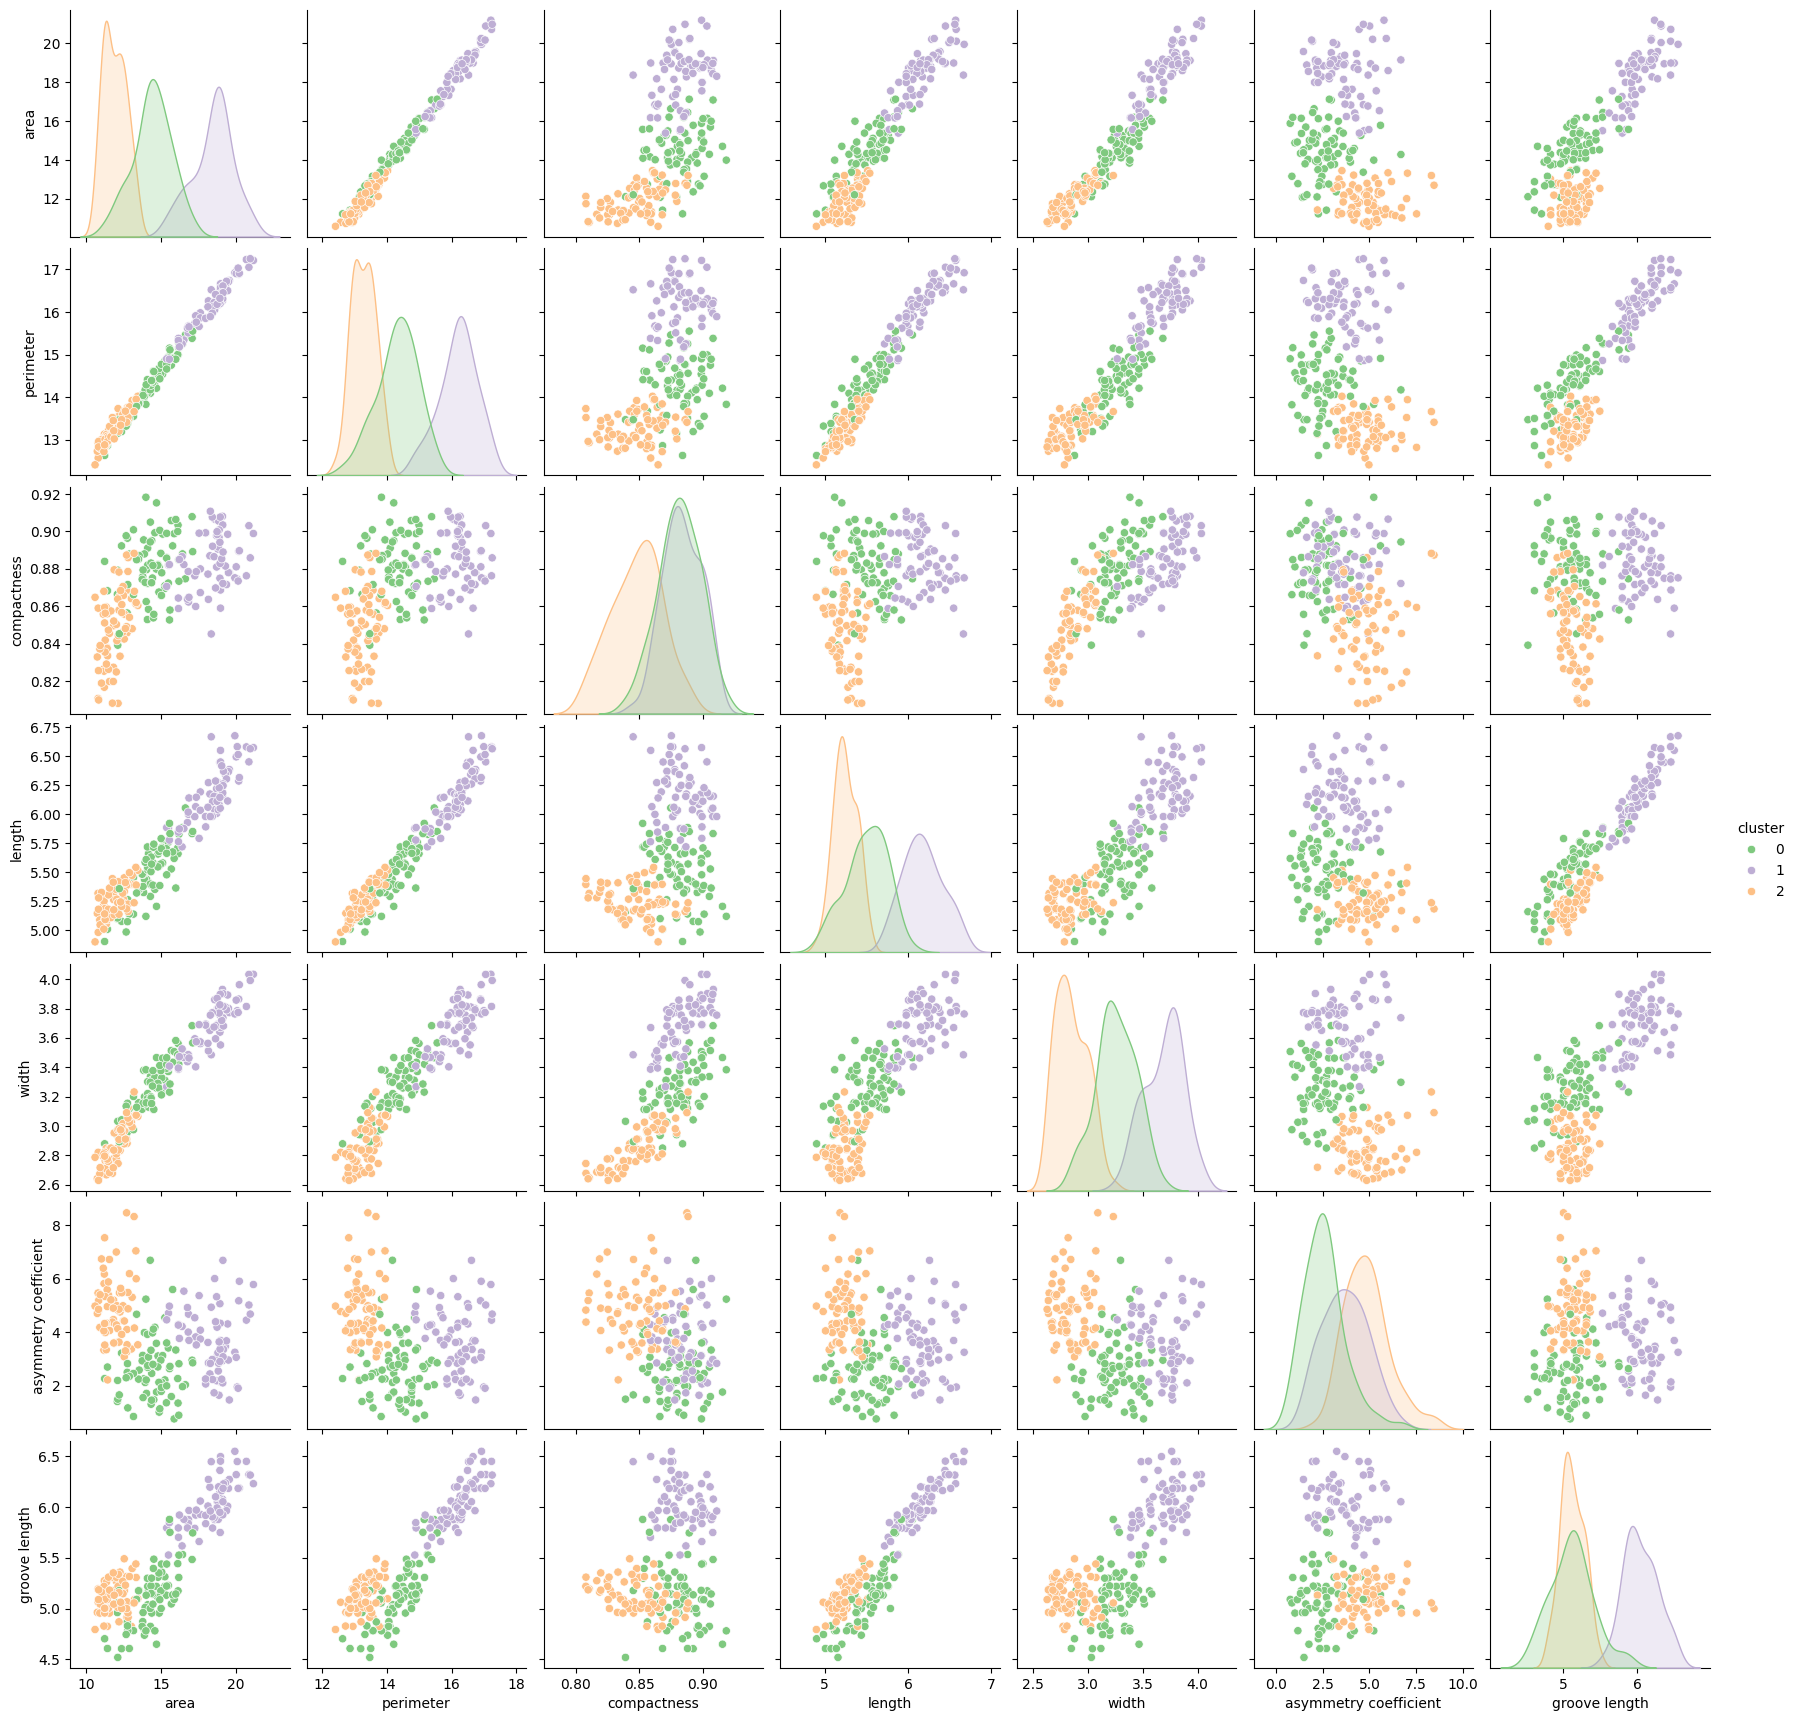

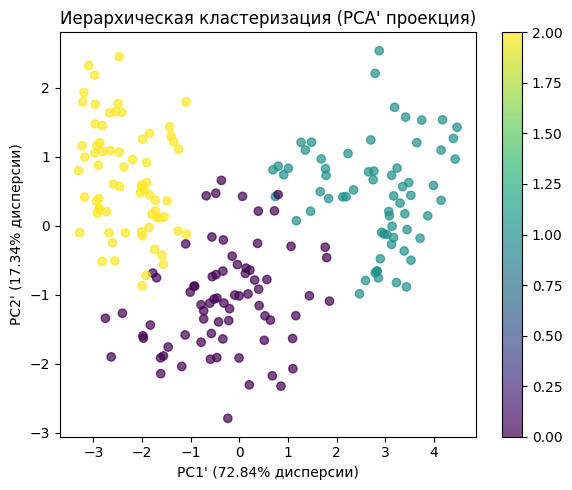

In [332]:
df_labels = df.copy()
df_labels = df_labels.assign(cluster=tree_labels)
sns.pairplot(df_labels, hue='cluster', palette='Accent')

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_pca)

cols = [f'PCA{i+1}\'' for i in range(pca_2d.n_components_)]
df_pca_2d = pd.DataFrame(data=X_pca_2d, columns=cols)
df_pca_2d = df_pca_2d.assign(cluster=tree_labels)

df_pca.head()

print(f"Объясненная дисперсия PCA\' (для двухмерной проекции): {pca_2d.explained_variance_ratio_}")
print(f'Суммарная объясненная дисперсия {sum(pca_2d.explained_variance_ratio_):.4f}')

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
scatter1 = ax1.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=tree_labels, cmap='viridis', alpha=0.7)
ax1.set_title('Иерархическая кластеризация (PCA\' проекция)')
ax1.set_xlabel(f'PC1\' ({pca_2d.explained_variance_ratio_[0]:.2%} дисперсии)')
ax1.set_ylabel(f'PC2\' ({pca_2d.explained_variance_ratio_[1]:.2%} дисперсии)')
plt.colorbar(scatter1, ax=ax1)

plt.tight_layout()
plt.show()

## Заключение

В ходе выполнения работы были изучены алгоритмы кластеризации, было проведено разбиение исходных данных на кластеры и выделено содержательное значение каждого кластера. Также было оценено качество обоих примененных методов кластеризации и интерпретированы результаты.

Используемые методы кластеризации K-Means и агломеративная иерархическая кластеризация продемонстрировали схожую и достаточно высокую эффективность для данной задачи сегментации зерен. K-means показал незначительно лучшие результаты по внутренним метрикам (силуэт 0.41 против 0.403, Калински-Харабаш 260.289 против 249.660), что свидетельствует о более четком разделении на кластеры. При этом внешние метрики практически одинаковые (Rand индекс 0.905 у обоих методов), что подтверждает сильное соответствие выделенных кластеров реальному распределению данных.

Оба метода успешно выделили три класса зерен: крупные с высокой компактностью и длинными желобками, средние с хорошей компактностью и короткими желобками, а также мелкие с низкой компактностью и высокой асимметрией. Несмотря на умеренные значения силуэта, указывающие на некоторое перекрытие кластеров, оба алгоритма обеспечили качественное и интерпретируемое разделение.